In [ ]:
import cv2
import sys
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from joblib import Parallel, delayed
import time
import concurrent.futures
import numpy as np

In [ ]:
nimh_path = './data/in/NIMH-CHEFS'
out_path = './data/out/NIMH-CHEFS'

image_path = './img.jpg'

### Folder utilities

In [ ]:
def get_subdirectories(path):
    return [os.path.join(path, folder)
            for folder in os.listdir(path) 
            if folder != '.ipynb_checkpoints' 
            and folder != '.DS_Store'
            and folder != '.Trash-0']

def get_subfolder_names(folder_list):
    return [os.path.basename(folder) for folder in folder_list]

def check_and_create_path(output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

def remove_file_extension(file_name):
    return os.path.splitext(file_name)[0]

def get_image_files_from_folder(folder_path):
    return [os.path.join(folder_path, file_name)
            for file_name in os.listdir(folder_path) 
            if file_name.endswith('.jpg')]

In [ ]:
folders = get_subdirectories(nimh_path)
display(folders)
folder_names = get_subfolder_names(folders)
display(folder_names)
images = get_image_files_from_folder(folders[0])
display(images)

### Image Utilities

In [ ]:
def save_image(path, img):
    cv2.imwrite(path, img)
    
def save_image_to_path(img, output_path, image_file_name, changes):
    remove_file_extension(image_file_name)
    image_out_path = f'{output_path}/{image_name}_{changes}.jpg'
    save_image(img, image_out_path)

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

def read_image(image_path):
    return cv2.imread(image_path)


### Graysscale

In [ ]:
def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [ ]:
image_path = './img.jpg'

img = read_image(image_path)

gray_img = convert_to_grayscale(img)

show_image(gray_img)

save_image('img_gray.jpg', gray_img)

### Find & Crop Faces

#### Face Detection Utilities -- OpenCV

In [ ]:
def find_faces(img):
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_classifier.detectMultiScale(gray_img, 1.25, 6)
    return faces

def crop_face(face, img):
    x, y, w, h = [ v for v in face ]
    cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 3)
    cropped_img = img[y:y+h, x:x+w]
    return cropped_img

In [ ]:
image_path = './img_gray.jpg'

img = read_image(image_path)

faces = find_faces(img)

for f in faces:
    cropped_img = crop_face(f, img)

show_image(cropped_img)

save_image('img_cropped.jpg', cropped_img)



### Resizing

In [ ]:
size = (256, 256)
downsampling = cv2.INTER_AREA
upsampling = cv2.INTER_CUBIC

In [ ]:
def resize_image(img, size, interpolation):
    return cv2.resize(img, dsize=size, interpolation=interpolation)

In [ ]:
image_path = './img_cropped.jpg'

img = read_image(image_path)

resized_img = resize_image(img, size, downsampling)

show_image(resized_img)

save_image('img_resized.jpg', cropped_img)

### Mediapipe

In [73]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title('Face Blendshapes')
  plt.tight_layout()
  plt.show()

In [74]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [75]:
# Create an FaceLandmarker object
base_options = python.BaseOptions(model_asset_path='./face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

W0000 00:00:1714726718.547339    1540 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [76]:
img = mp.Image.create_from_file('./img.jpg')

In [78]:
# Detect face landmarks from the input image
detection_result = detector.detect(img)

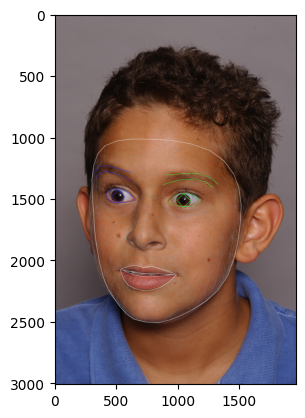

In [79]:
# Process the detection result, visualize it
annotated_image = draw_landmarks_on_image(img.numpy_view(), detection_result)
res_img = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2GRAY)

plt.imshow(annotated_image, cmap='gray')
plt.show()